In [16]:
import nltk.translate.chrf_score
import random
import matplotlib.pyplot as plt
%matplotlib inline
#plt.switch_backend('agg')

Grammar Error Correction with Transformers
======================================================

This notebook shows how to train a GEC model based on transformers.

Table of Contents

- [1. Data Sourcing and Processing](#1)
    - Tokenizing and Embedding
    - Collation
- [2. Seq2Seq Network using Transformer](#2)
    - Positional encoding
    - Multi-head attention
- [3. Model definition](#3)
- [4. Training](#4)
- [5. Evaluation](#5)
- [6. Results](#6)
- [7. References](#7)

<a name='1'></a>
# 1. Data Sourcing and Processing

C4 200M dataset from Google Research is used in this notebook. You can find more information about the C4 200M dataset on Google Research's [BEA 2021 paper](https://aclanthology.org/2021.bea-1.4/) (Stahlberg and Kumar, 2021).

The already [processed dataset](https://huggingface.co/datasets/liweili/c4_200m) was extracted from Huggingface in CSV format, then was transformed to HDF5 format for better manageability. The conversion process is detailed in ``utils.py``, and was based on this [notebook](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mechanics/custom-data-loader-csv.ipynb).
The final version of the dataset is uploaded on [Kaggle](https://www.kaggle.com/datasets/dariocioni/c4200m).

A custom class ``Hdf5Dataset`` based on ``torch.utils.data.Dataset`` is developed, which yields a pair of source-target raw sentences.

| source                                             | target                                                  |
|----------------------------------------------------|---------------------------------------------------------|
| Much many brands and sellers still in the market.  | Many brands and sellers still in the market.            |
| She likes playing in park and come here every week | She likes playing in the park and comes here every week |

To be able to train on a arbitrary subset of a single file, the dataset only reads chunks of length ``num_entries`` if the parameter is specified . In order to capture more examples, a different chunk can be randomly chosen at each epoch by specifying ``randomized=True``

In [17]:
# Import libraries
import torch
import pathlib as pl

In [18]:
import h5py
from torch.utils.data import Dataset
random.seed(42)

class Hdf5Dataset(Dataset):
    """Custom Dataset for loading entries from HDF5 databases"""

    def __init__(self, h5_path, transform=None,num_entries = None,randomized=False):

        self.h5f = h5py.File(h5_path, 'r')
        self.size = self.h5f['labels'].shape[0]
        self.transform = transform
        self.randomized = randomized
        self.max_index = num_entries if num_entries is not None else self.size
        #Chooses an offset for the dataset when using a subset of a Hdf5 file
        if randomized:
            self.offset = random.choice(range(0,self.size//self.max_index))*self.max_index
        else:
            self.offset = 0


    def __getitem__(self, index):
        if index > self.max_index:
            raise StopIteration
        input = self.h5f['input'][self.offset+index].decode('utf-8')
        label = self.h5f['labels'][self.offset+index].decode('utf-8')
        if self.transform is not None:
            features = self.transform(input)
        return input, label

    def __len__(self):
        return self.max_index

    def reshuffle(self):
        if self.randomized:
            self.offset = random.choice(range(0,self.size//self.max_index))*self.max_index
        else:
            print("Please set randomized=True")

In [19]:
from typing import List
from tqdm import tqdm
from torchtext.data import get_tokenizer

SRC_LANGUAGE = 'incorrect'
TGT_LANGUAGE = 'correct'
MAX_LENGTH = 5000
VOCAB_SIZE = 20000
N_SAMPLES = 100000

# Place-holders
token_transform =get_tokenizer('basic_english')
vocab_transform = None

#folder = 'dataset'
# train_filename = 'train.hf5'
# valid_filename = 'valid.hf5'
# test_filename = 'test.hf5'
# vocab_path = 'vocab/vocab_20K.pth'
# embedding_path = 'vocab/glove_42B_300d_20K.pth'
# checkpoint_folder = 'G:\Il mio Drive\Colab Notebooks\GEC_Soft_Masked_BERT\checkpoints'

##COLAB
folder = '../input/c4200m/hdf5'
train_filename = 'C4_200M.hf5-00000-of-00010'
valid_filename = 'C4_200M.hf5-00001-of-00010'
test_filename = 'C4_200M.hf5-00002-of-00010'
embedding_path = '/content/drive/MyDrive/Colab Notebooks/GEC_Soft_Masked_BERT/vocab/glove_42B_300d_20K.pth'
vocab_path = '../input/c4-200m-vocabulary/vocab_20K.pth'
checkpoint_folder = './'

### Tokenizing and Embedding
Data is then tokenized by the standard tokenizer from ``torchtext`` library, which performs basic normalization and splitting by space. Normalization includes
- lowercasing
- complete some basic text normalization for English words as follows:
    add spaces before and after '\''
    remove '\"',
    add spaces before and after '.'
    replace '<br \/>'with single space
    add spaces before and after ','
    add spaces before and after '('
    add spaces before and after ')'
    add spaces before and after '!'
    add spaces before and after '?'
    replace ';' with single space
    replace ':' with single space
    replace multiple spaces with single space

A vocabulary was produced based on 1M samples of the training dataset, using ``build_vocab`` function inside ``vocab.py``.

I then evaluated pre-trained embeddings and confronted with the nn.Embedding, both with embeddings of length 300.
- ``GloVe`` Embeddings were trained on Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors)
- Pretrained embeddings were aligned with the vocabulary using ``load_pretrained_embs`` function inside ``vocab.py``.

In [20]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<UNK>', '<PAD>', '<BOS>', '<EOS>']

vocab_transform = torch.load(vocab_path)
# embeddings = torch.load(embedding_path)
embeddings = None

### Collation

An iterator over ``Hdf5dataset`` yields a pair of raw strings.
We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network.
Below I defined a collate function that converts batch of raw strings into batch tensors that can be fed directly into the model.

In [21]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# def glove_transform(tokens: List[str]):



# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    #truncate sequences longer than MAX_LENGTH
    if(len(token_ids) > MAX_LENGTH - 2):
        token_ids = token_ids[0:MAX_LENGTH -2]
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(token_transform,
                                       vocab_transform,
                                       tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample.rstrip("\n")))
        tgt_batch.append(text_transform(tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Here's an example of the encoding

In [22]:
text = ('Data Maining is awesome!','Data Mining is awesome!')
src,tgt = collate_fn([text])
print(src,tgt)

tensor([[   2],
        [ 157],
        [   0],
        [  13],
        [1480],
        [  32],
        [   3]]) tensor([[   2],
        [ 157],
        [1185],
        [  13],
        [1480],
        [  32],
        [   3]])


<a name='2'></a>
# 2. Seq2Seq Network using Transformer

Transformer is a Seq2Seq model introduced in [“Attention is all you need”](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>) paper for solving machine translation tasks.
Below, we will create a Seq2Seq network that uses Transformer. The network consists of three parts:
1) The embedding layer. This layer converts tensor of input indices into corresponding tensor of input embeddings.
    These embedding are further augmented with ``Positional Encodings``, to provide position information of input tokens to the model.
2) The actual [Transformer](<https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>) model.
3) The output of Transformer model is finally passed through a linear layer that give un-normalized probabilities for each token in the target language.

### Positional Encoding
Differently from RNNs, Transformers don't have a notion of relative or absolute position of the tokens in the input.
One solution is to combine the input embeddings with positional embeddings, specific to each position in an input sequence.
A solution that is not biased towards the initial positions consists in a combination of sine and cosine functions of different frequencies ([Vaswani et al. ,2017](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>))

Given an embedding of length $d$, a position in the sequence $pos$ and the $i$-th dimension of the embedding, the position embedding is calculated as

$$PE_{(pos,2i)} = \sin(pos/10000^{2i/d})\quad,\quad PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d})$$

Dropout is also added to the sums of the embeddings and the positional encodings in both the encoder and decoder.

<img src="img/pos_enc.png">

### Multi-head attention
A single transformer block cannot capture all the different kinds of simultaneous relations among its inputs.
To address this problem, Transformers can use multiple self-attention heads, residing in parallel layers and with different parameter sets.
Each head $i$ will have a different set of key, query and value matrices $W_i^K,W_i^Q,W_i^V$ and will project into different embeddings for each head.
The different embeddings are finally reduced to the original input dimension, using a trainable linear projection $W^O$

<img src="img/multihead.png">




In [23]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer

import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size,embedding_weights=None):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        if embedding_weights is not None:
            self.embedding.weight = torch.nn.Parameter(torch.from_numpy(embedding_weights).float())
            # self.embedding.weight.requires_grad =False
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 100,
                 dropout: float = 0.1,
                 embedding_weights = None):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size,embedding_weights)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size,embedding_weights)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor, src_padding_mask: Tensor = None):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask, src_padding_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

During training, we need a subsequent word mask that will prevent model to look into the future words when making predictions. We will also need masks to hide source and target padding tokens. Below, let's define a function that will take care of both.




In [24]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

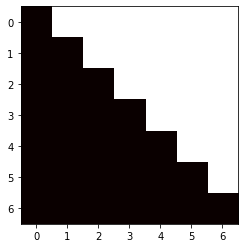

In [25]:
example_mask = create_mask(src,tgt)
_ = plt.imshow(example_mask[1].cpu(),cmap='hot')
plt.show()

<a name="3"></a>
# 3. Model definition
The model is instantiated in the ``Seq2SeqTransformer`` wrapper.
I used the cross-entropy loss as the loss function and Adam optimizer for training.
The regularization hyperparameters were chosen as in ([Vaswani et al. ,2017](<https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>))

In [26]:
torch.manual_seed(0)

VOCAB_SIZE = len(vocab_transform.vocab.itos_)
EMB_SIZE = 100
NHEAD = 2
FFN_HID_DIM = 128
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

#To save and retrieve checkpoints
model_name = 'transformer_%dE_%dH_%dF_%d_%d.pt'%(EMB_SIZE,NHEAD,FFN_HID_DIM,NUM_DECODER_LAYERS,NUM_DECODER_LAYERS)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, VOCAB_SIZE, VOCAB_SIZE, FFN_HID_DIM,embedding_weights=embeddings)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [27]:
from torch.utils.data import DataLoader
from torch.utils.data import IterableDataset

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Hdf5Dataset(pl.Path(folder)/train_filename,num_entries=N_SAMPLES,randomized=True)
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Hdf5Dataset(pl.Path(folder)/valid_filename,num_entries=N_SAMPLES)
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in tqdm(val_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        with torch.no_grad():
            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)



<a name="4"></a>
# 4. Training
Now we have all the ingredients to train our model:
The training is performed on 10 epochs.

In [28]:
checkpoint = torch.load("../input/transformer-1h-32b-nopt/transformer_100E_2H_128F_3_3.pt")
transformer.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [29]:
from timeit import default_timer as timer
NUM_EPOCHS = 3

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    torch.save({
        'epoch': epoch,
        'model_state_dict': transformer.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, pl.Path(checkpoint_folder)/model_name)

100%|██████████| 6250/6250 [03:51<00:00, 27.01it/s]


Epoch: 1, Train loss: 2.555, Val loss: 2.303, Epoch time = 327.702s


100%|██████████| 6250/6250 [03:51<00:00, 27.02it/s]


Epoch: 2, Train loss: 2.488, Val loss: 2.252, Epoch time = 326.513s


100%|██████████| 6250/6250 [03:50<00:00, 27.08it/s]


Epoch: 3, Train loss: 2.441, Val loss: 2.218, Epoch time = 326.878s


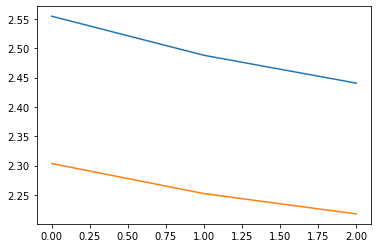

In [30]:
_ = plt.plot(train_losses)
_ = plt.plot(val_losses)

# 5. Evaluation
<a name="5"></a>We can evaluate the produced correction using the ``greedy_decode`` function.
In this function, at each timestep the most probable token is selected as correction at each time step, without evaluating its impact on the rest of the sequence.
A better way could be to use a ``Beam Search``, choosing $k$ tokens at each timestep and then scoring each node with its log probability.

In [31]:
# function to generate output sequence using greedy algorithm
# input: (input_length,batch_size)
# output: (input_length)
def greedy_decode(model, src, src_mask, src_padding_mask, max_len):
    batch_size = src.shape[1]

    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    src_padding_mask = src_padding_mask.to(DEVICE)
    unfinished_sequences = torch.ones(1,batch_size).to(DEVICE)

    context = transformer.encode(src, src_mask,src_padding_mask).to(DEVICE)
    ys = torch.ones(1, batch_size).fill_(BOS_IDX).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, context, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob,dim=1)
        #Predict only PAD_IDX after EOS_IDX is predicted
        next_word = next_word * unfinished_sequences + (1-unfinished_sequences) * PAD_IDX
        ys = torch.cat([ys,
                        next_word], dim=0)
        # if eos_token was found in one sentence, set sentence to finished

        unfinished_sequences = unfinished_sequences.mul((next_word != EOS_IDX).long())
        #
        # stop when each sentence is finished, or if we exceed the maximum length
        if unfinished_sequences.max() == 0:
            break
    return ys.int()


# actual function to correct input sentence
def correct(src_sentence: str, model: torch.nn.Module):
    model.eval()
    src = text_transform(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    src_padding_mask = (torch.zeros(1, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask,src_padding_mask, max_len=num_tokens + 5).flatten()
    return ' '.join([vocab_transform.vocab.itos_[i] for i in tgt_tokens if i not in [PAD_IDX,BOS_IDX,EOS_IDX]])

In [32]:
checkpoint = torch.load(pl.Path(checkpoint_folder)/model_name)
transformer.load_state_dict(checkpoint['model_state_dict'])

transformer.eval()

# Pick one in 18M examples
test_iter = Hdf5Dataset(pl.Path(folder)/test_filename,num_entries=None)

src,trg = random.choice(test_iter)

print("input: \"",src,"\"")
print("target: \"",trg,"\"")

prediction = correct(src,transformer)

print("prediction: \"%s\""%prediction)

input: " School teacher's exam postponed for doing not?? "
target: " Clerical exam postponed or not?? "
prediction: "school teacher ' s exam , the <UNK> for doing not ?"


In [46]:
from torch.utils.data import DataLoader
from nltk.translate import chrf_score,bleu_score
import re

def test_collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform(src_sample.rstrip("\n")))
        tgt_batch.append(tgt_sample.rstrip("\n"))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

def test(model):
    model.eval()
    score=0

    test_iter = Hdf5Dataset(pl.Path(folder)/test_filename,num_entries=10000)
    test_dataloader = DataLoader(test_iter, batch_size=64,collate_fn=test_collate_fn)
    for src, tgt in tqdm(test_dataloader):
        src_mask, _, src_padding_mask, _ = create_mask(src, src)
        num_tokens = src.shape[0]
        with torch.no_grad():
            pred_tokens = greedy_decode(
                model,  src, src_mask,src_padding_mask, max_len=num_tokens + 5).T.flatten()
            pred_sentences = ' '.join([vocab_transform.vocab.itos_[i] for i in pred_tokens if i not in [PAD_IDX,BOS_IDX,EOS_IDX]])
            pred_sentences = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', pred_sentences)
        score += chrf_score.sentence_chrf(pred_sentences,' '.join(tgt))
    
    return score/len(test_dataloader)

In [47]:
checkpoint = torch.load(pl.Path(checkpoint_folder)/model_name)
transformer.load_state_dict(checkpoint['model_state_dict'])

transformer.eval()

# chrf = chrf_score.chrf_precision_recall_fscore_support

# print(chrf_score.chrf_precision_recall_fscore_support('Thinking of hiring The Pass Street Food Cafe for your event?','thinking of hiring the pass street food cafe for your event',n=1))

test_loss = test(transformer)
print(test_loss)

# print(nltk.translate.chrf_score.sentence_chrf('x',['y']))

# bleu = bleu_score.sentence_bleu()
#
# test_loss = test(transformer,bleu)
# print(test_loss)

100%|██████████| 157/157 [06:11<00:00,  2.37s/it]

0.6367178516596114


<a name="6"></a>
# 6. Results

<a name="7"></a>
# 7. References

1. [Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
2. [The annotated transformer](http://nlp.seas.harvard.edu/annotated-transformer)
3. [Pytorch tutorial on NMT with transformers](https://pytorch.org/tutorials/beginner/translation_transformer.html)
4. [Speech and Language Processing, Jurafsky and Martin](https://web.stanford.edu/~jurafsky/slp3/)

